In [2]:
import argparse
import torch
import torchvision
from torchvision.datasets import STL10, ImageFolder, CIFAR10, CIFAR100
from solo.data.pretrain_dataloader import dataset_with_index
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import transforms
from transformers import pipeline
import tqdm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import os
from transformers import Owlv2Processor, Owlv2ForObjectDetection, Owlv2ImageProcessor
from PIL import ImageDraw
from IPython.display import Image 

MEANS_N_STD = {
    "cifar10": ((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    "cifar100": ((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
    "stl10": ((0.4914, 0.4823, 0.4466), (0.247, 0.243, 0.261)),
    "imagenet100": (IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    "imagenet": (IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
}


/home/AD/ofsk222/miniconda3/envs/solo-learn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_data_path = f"datasets/stl10"
dataset = "stl10"
download = True

mean, std = MEANS_N_STD[dataset]
augmentations = []
augmentations.append(transforms.ToTensor())
augmentations.append(transforms.ToPILImage())
augmentations.append(transforms.ToTensor())
augmentations = transforms.Compose(augmentations)
augmentations = augmentations if augmentations != [] else None

train_dataset = dataset_with_index(STL10)(
    train_data_path,
    split="train+unlabeled",
    download=download,
    transform=augmentations,
)

Files already downloaded and verified


In [4]:
# load csv file
df = pd.read_csv("stl10_preprocessed_info.csv")

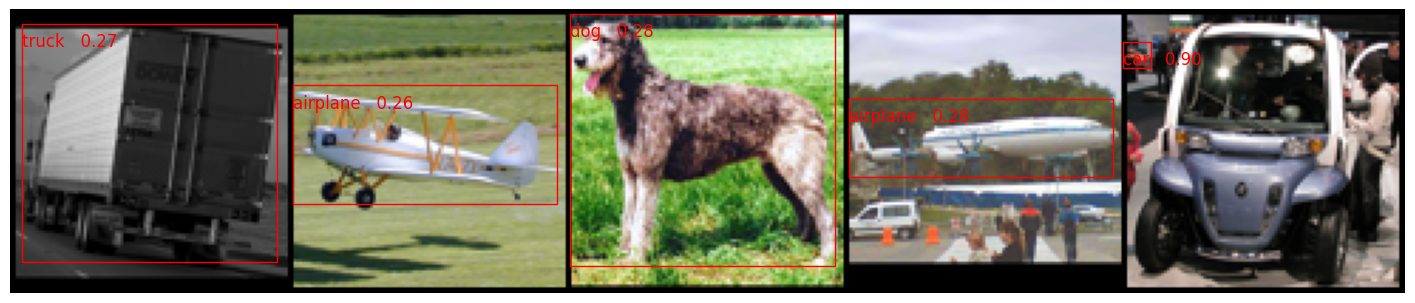

3.75 4.5 93.74995200000001 88.5


/home/AD/ofsk222/miniconda3/envs/solo-learn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


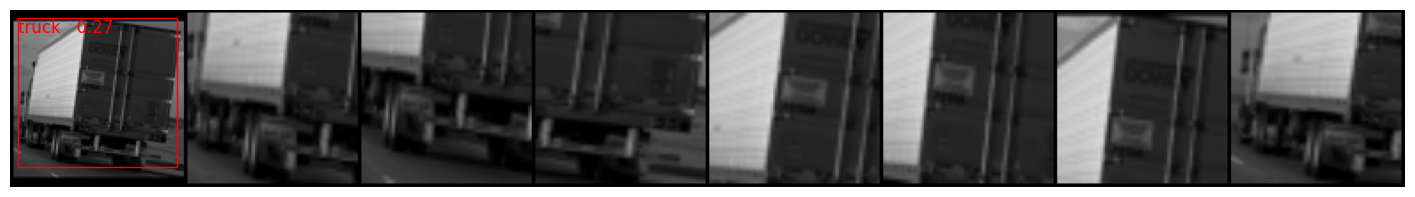

3.75 4.5 93.74995200000001 88.5


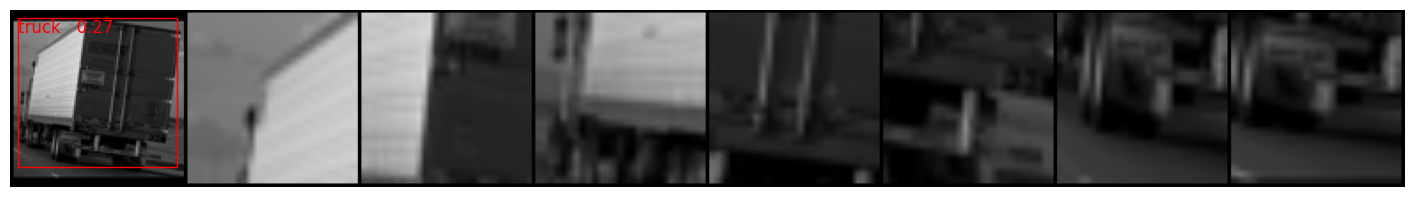

1.3125024 26.250048 94.5 68.25004799999999


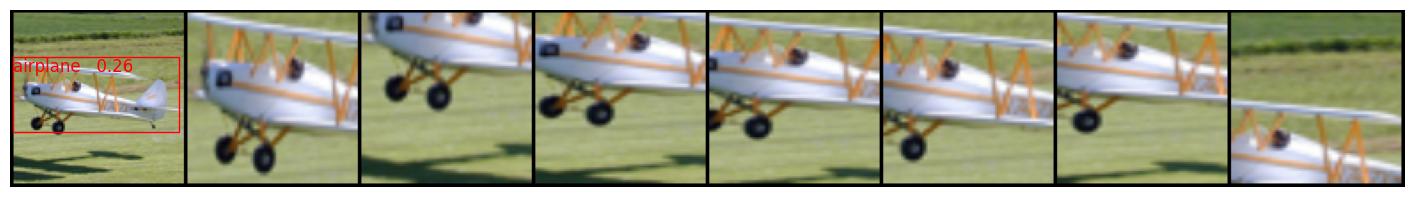

1.3125024 26.250048 94.5 68.25004799999999


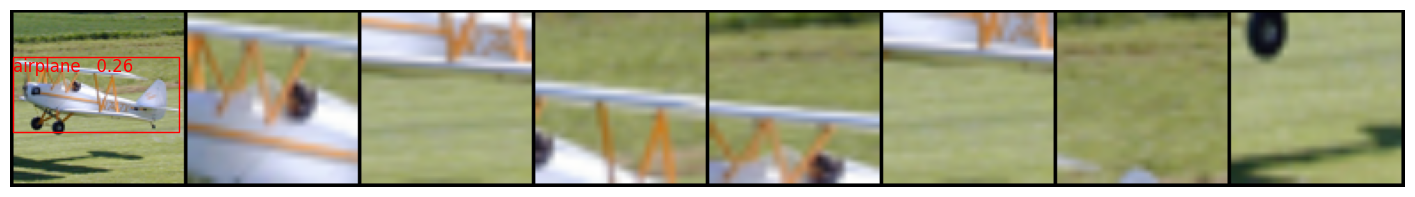

0.9374995199999999 0.9374995199999999 94.5 90.0


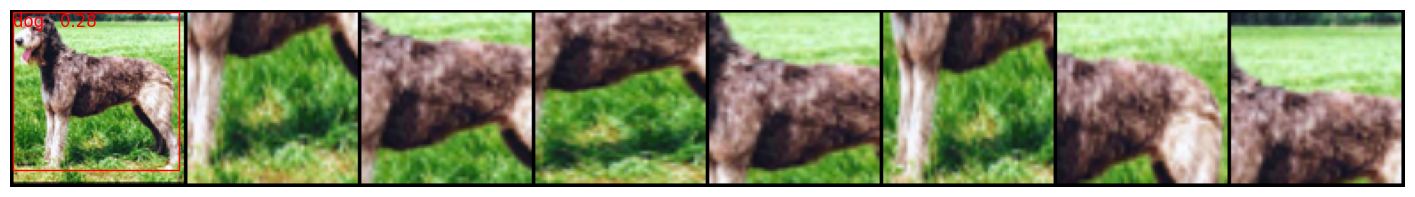

0.9374995199999999 0.9374995199999999 94.5 90.0


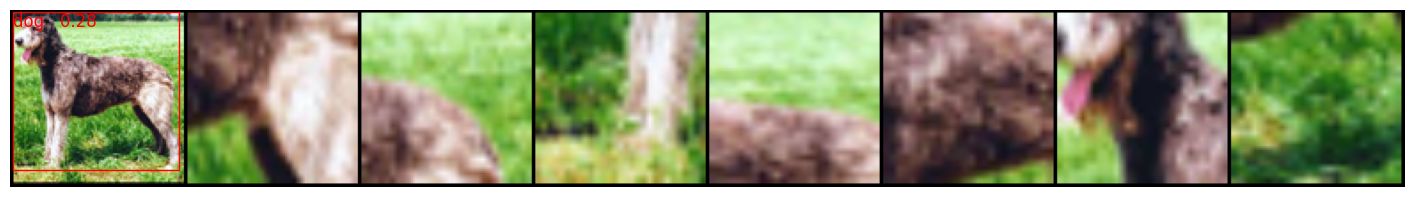

1.3125024 31.125023999999996 94.5 58.5


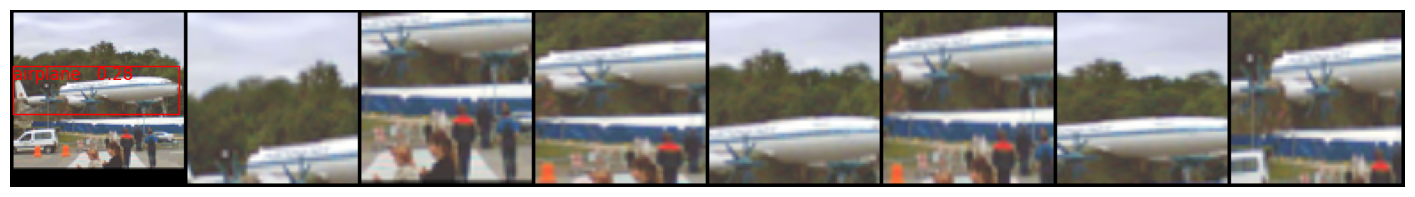

1.3125024 31.125023999999996 94.5 58.5


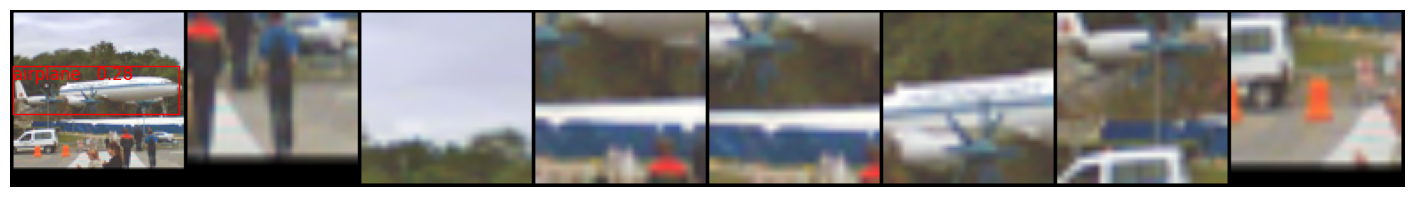

-0.07031251200000001 11.062464 9.843744000000001 20.062464


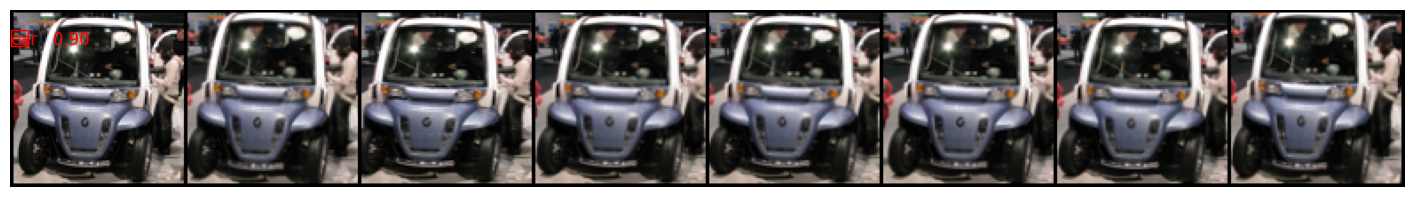

-0.07031251200000001 11.062464 9.843744000000001 20.062464


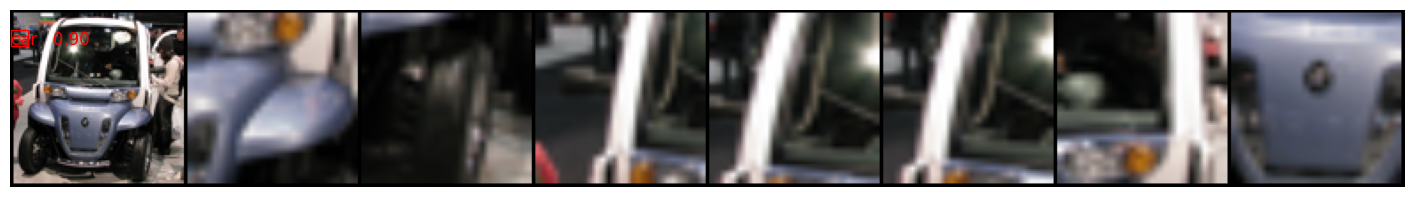

In [5]:
# plot image 50

indices = list(range(70, 75))
imgs  = [train_dataset[i][1] for i in indices]

grid = torchvision.utils.make_grid(imgs, scale_each=True, padding=2)


# draw bounding box from df for each index
fig, ax = plt.subplots()
ax.imshow(grid.permute(1, 2, 0))
for i, index in enumerate(indices):
    row = df.iloc[index]
    x1 = max(96*i, row["xmin"]*96 + 98*i)
    y1 = row["ymin"]*96
    x2 = max(96*i, row["xmax"]*96 + 98*i)
    y2 = row["ymax"]*96

    if row["predicted_label"] != 'none':
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1+8, row["predicted_label"] + f'   {row["rrc_area_lower_bound"]:.2f}', color='r', fontsize=12)

plt.axis('off')
fig = plt.gcf()
fig.set_size_inches(18, 18)
plt.show()

# for each image, show several randomresized crops
for i, img in enumerate(imgs):
    row = df.iloc[indices[i]]
    min_crop_size = row["rrc_area_lower_bound"]
    
    cropper = transforms.RandomResizedCrop(96, scale=(min_crop_size, min_crop_size))
    cropped_imgs = [img] + [cropper(img) for _ in range(7)]
    grid = torchvision.utils.make_grid(cropped_imgs, scale_each=True, padding=2)

    fig, ax = plt.subplots()
    
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(18, 18)

    x1 = row["xmin"]*96
    y1 = row["ymin"]*96
    x2 = row["xmax"]*96
    y2 = row["ymax"]*96
    print(x1, y1, x2, y2)

    if row["predicted_label"] != 'none':
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1+8, row["predicted_label"] + f'   {row["rrc_area_lower_bound"]:.2f}', color='r', fontsize=12)

    plt.show()

    cropper = transforms.RandomResizedCrop(96, scale=(0.08, 0.08))
    cropped_imgs = [img] + [cropper(img) for _ in range(7)]
    grid = torchvision.utils.make_grid(cropped_imgs, scale_each=True, padding=2)

    fig, ax = plt.subplots()
    
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(18, 18)

    x1 = row["xmin"]*96
    y1 = row["ymin"]*96
    x2 = row["xmax"]*96
    y2 = row["ymax"]*96
    print(x1, y1, x2, y2)

    if row["predicted_label"] != 'none':
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1+8, row["predicted_label"] + f'   {row["rrc_area_lower_bound"]:.2f}', color='r', fontsize=12)

    plt.show()